In [33]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.datasets import load_boston
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style="darkgrid") 

# Множественная регрессия

## Данные

In [34]:
dataset = pd.read_csv("data-fic.csv")

In [64]:
dataset

,y,x1,x2,x3
0,45,23,0,0
1,48,25,0,0
2,54,24,0,0
3,57,29,0,0
4,65,38,1,0
5,69,36,0,0
6,78,40,1,0
7,83,59,0,1
8,98,56,0,1
9,104,64,1,0


In [36]:
dataset.describe()

,y,x1,x2,x3
count,11.000000,11.000000,11.000000,11.000000
mean,73.454545,40.636364,0.363636,0.181818
std,22.295128,15.061691,0.504525,0.404520
min,45.000000,23.000000,0.000000,0.000000
25%,55.500000,27.000000,0.000000,0.000000
50%,69.000000,38.000000,0.000000,0.000000
75%,90.500000,54.500000,1.000000,0.000000
max,107.000000,64.000000,1.000000,1.000000


In [37]:
X = dataset.loc[:, dataset.columns != 'y']
y = dataset['y'].values

In [38]:
X.head()

,x1,x2,x3
0,23,0,0
1,25,0,0
2,24,0,0
3,29,0,0
4,38,1,0


In [39]:
print(y)

[ 45  48  54  57  65  69  78  83  98 104 107]


## Построение со всеми параметрами

In [40]:
regr = linear_model.LinearRegression()
model = regr.fit(X, y)
Xc = sm.add_constant(X)
tmp = sm.OLS(y, Xc)
result = tmp.fit()

In [41]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     21.20
Date:                Tue, 30 May 2023   Prob (F-statistic):           0.000687
Time:                        09:41:37   Log-Likelihood:                -36.521
No. Observations:                  11   AIC:                             81.04
Df Residuals:                       7   BIC:                             82.63
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.2761     10.411      1.371      0.213     -10.343      38.895
x1             1.4717      0.354      4.152      0.004       0.634       2.310
x2             2.4797      9.431      0.263      0.800     -19.822      24.781
x3            -8.3974     12.771     -0.658      0.532     -38.597      21.802
==============================================================================
Omnibus:                        0.529   Durbin-Watson:                   2.825
Prob(Omnibus):                  0.768   Jarque-Bera (JB):                0.562
Skew:                           0.331   Prob(JB):                        0.755
Kurtosis:                       2.112   Cond. No.                         291.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Результат

In [42]:
coeff = result.params

In [43]:
def getFunc(coeff, k):
    res = ""
    for i in range(0, len(coeff)):
        if(i == 0):
            res += str(round(coeff[i], 4))
            continue
        
        if(coeff[i] > 0):
            res += ' + ' + str(round(coeff[i], k)) + ' * x' + str(i)
        else:
            res += ' - ' + str(abs(round(coeff[i], k))) + ' * x' + str(i)
    return res

In [44]:
print('f =', getFunc(coeff, 4))

f = 14.2761 + 1.4717 * x1 + 2.4797 * x2 - 8.3974 * x3


#### Коэффицент множественной дисперсии

In [45]:
R_2 = result.rsquared

In [46]:
print(f'Модель регрессии на {round(R_2, 3) * 100}% объясняет поведение\n' + 
      f'результативного признака y в зависимости от\n'+
      f'фактора x, {(1 - round(R_2, 3)) * 100}% на долю неучтенных факторов')

Модель регрессии на 90.10000000000001% объясняет поведение
результативного признака y в зависимости от
фактора x, 9.899999999999999% на долю неучтенных факторов


#### Средняя ошибка апроксимации

In [47]:
def meanErrorAproc(y, y_cal):
    A = 0
    for i in range(len(y)):
        A += abs((y_cal[i] - y[i]) / y[i])
    A /= len(y)
    return A * 100

In [48]:
print('Средняя ошибка апроксимации:', round(meanErrorAproc(y, model.predict(X)), 2), '%')

Средняя ошибка апроксимации: 7.15 %


#### Критерий Фишера. Оценка статистической значимости уравнения регрессии

In [49]:
F_calc = result.fvalue
F_tabl = stats.f.isf(0.05, len(X.columns), len(y) - len(X.columns) - 1)
print(F_calc, F_tabl)

21.199306682291617 4.346831399907815


In [50]:
if (F_calc > F_tabl):
    print('Статистическая значимость уравнение регрессии признается')
else:
    print('Статистическая значимость уравнение регрессии не признается')

Статистическая значимость уравнение регрессии признается


## Оптимальное построение

In [51]:
matriz_corr = dataset.corr()
print(matriz_corr)

           y        x1        x2        x3
y   1.000000  0.933829  0.535023  0.377997
x1  0.933829  1.000000  0.427090  0.553564
x2  0.535023  0.427090  1.000000 -0.356348
x3  0.377997  0.553564 -0.356348  1.000000


In [52]:
fewX = dataset[['x3', 'x2']]
regr = linear_model.LinearRegression()
model_opt = regr.fit(fewX, y)
Xc = sm.add_constant(fewX)
tmp = sm.OLS(y, Xc)
result = tmp.fit()

In [53]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     7.650
Date:                Tue, 30 May 2023   Prob (F-statistic):             0.0139
Time:                        09:41:39   Log-Likelihood:                -43.353
No. Observations:                  11   AIC:                             92.71
Df Residuals:                       8   BIC:                             93.90
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         54.6000      6.532      8.359      0.000      39.537      69.663
x3            35.9000     12.220      2.938      0.019       7.720      64.080
x2            33.9000      9.798      3.460      0.009      11.306      56.494
==============================================================================
Omnibus:                        0.242   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.886   Jarque-Bera (JB):                0.405
Skew:                          -0.106   Prob(JB):                        0.816
Kurtosis:                       2.084   Cond. No.                         3.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
coeff = result.params

In [55]:
def getFunc(coeff, k):
    res = ""
    for i in range(0, len(coeff)):
        if(i == 0):
            res += str(round(coeff[i], 4))
            continue
        
        if(coeff[i] > 0):
            res += ' + ' + str(round(coeff[i], k)) + ' * x' + str(i)
        else:
            res += ' - ' + str(abs(round(coeff[i], k))) + ' * x' + str(i)
    return res

In [56]:
print('f =', getFunc(coeff, 4))

f = 54.6 + 35.9 * x1 + 33.9 * x2


In [57]:
R_2 = result.rsquared

In [58]:
print(f'Модель регрессии на {round(R_2, 3) * 100}% объясняет поведение\n' + 
      f'результативного признака y в зависимости от\n'+
      f'фактора x, {(1 - round(R_2, 3)) * 100}% на долю неучтенных факторов')

Модель регрессии на 65.7% объясняет поведение
результативного признака y в зависимости от
фактора x, 34.3% на долю неучтенных факторов


In [59]:
def meanErrorAproc(y, y_cal):
    A = 0
    for i in range(len(y)):
        A += abs((y_cal[i] - y[i]) / y[i])
    A /= len(y)
    return A * 100

In [60]:
print('Средняя ошибка апроксимации:', round(meanErrorAproc(y, model_opt.predict(fewX)), 2), '%')

Средняя ошибка апроксимации: 14.52 %


In [61]:
F_calc = result.fvalue
F_tabl = stats.f.isf(0.05, len(fewX.columns), len(y) - len(fewX.columns) - 1)
print(F_calc, F_tabl)

7.649914508061812 4.458970107524511


In [62]:
if (F_calc > F_tabl):
    print('Статистическая значимость уравнение регрессии признается')
else:
    print('Статистическая значимость уравнение регрессии не признается')

Статистическая значимость уравнение регрессии признается


ValueError: x and y must be the same size

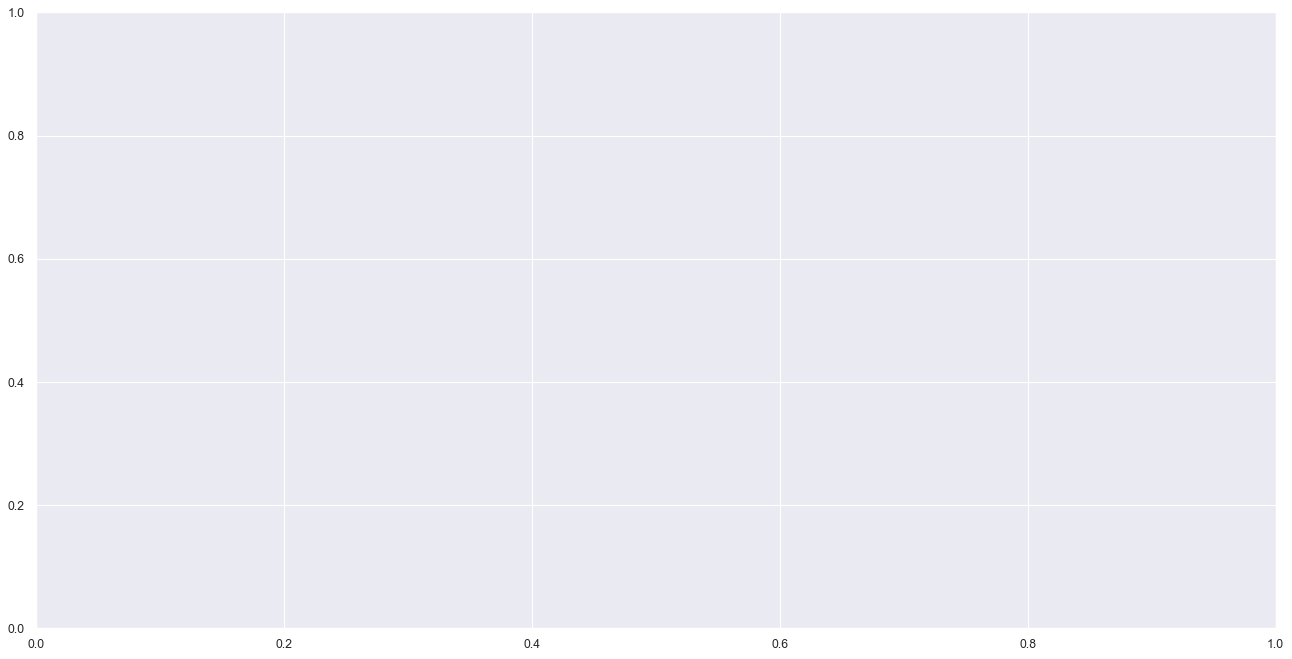

In [63]:
plt.figure(figsize = (20,10), dpi = 80)
polyline = np.linspace(1, 25, 25)
plt.scatter(polyline, model_opt.predict(fewX), label='New')
plt.scatter(polyline, model.predict(X), label='Old')
plt.legend()
plt.show()